In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

### Evaluate performance of model trained on clean labels

In [15]:
exp_suffix = 'clean'
alpha = 1.0

In [ ]:
prd_path = f'/vol/biomedic3/es525/mammo-label-bias/output-density/resnet18-b32-fixed-alpha-1.0-ffdm-lr-0.00001-binary_singledensity_3manu_pseudo_balanced'
df_prd = pd.read_csv(os.path.join(prd_path, 'predictions.csv'))

In [ ]:
#get metadata for predictions
md = pd.read_csv(f'/vol/biomedic3/es525/mammo-label-bias/modified_metadata/embed-non-negative_singledensity_3manu_pseudo_balanced.csv') 
md['image_id'] = [img_path.split('/')[-1] for img_path in md.image_path.values]

/tmp/ipykernel_674706/1974549253.py:2: DtypeWarning: Columns (31,32,51) have mixed types. Specify dtype option on import or set low_memory=False.
  md = pd.read_csv(f'/vol/biomedic3/es525/mammo-net/modified_metadata/embed-non-negative_singledensity_3manu_pseudo_balanced.csv') # subject level


In [6]:
print(len(md))
print(len(df_prd))

192090
38538


In [7]:
df = pd.merge(df_prd, md, how='inner', on=['image_id'])
print(len(df))

38538


In [12]:
preds = np.stack([df['class_0'],df['class_1']]).transpose()
true_targets = np.array(df['density_binary'])


In [13]:
true_fpr, true_tpr, true_thresh = roc_curve(true_targets, preds[:,1])
true_roc_auc = auc(true_fpr, true_tpr)


In [14]:
labels = np.argmax(preds, axis=1)
df['pred']=labels

### AUC on test set

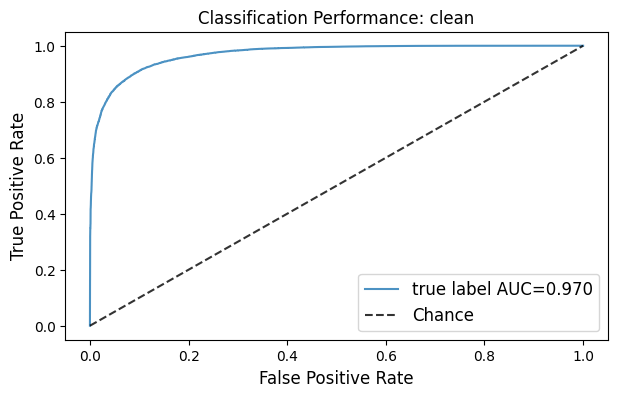

In [16]:
fig, ax = plt.subplots(figsize=(7,4))
plt.plot(true_fpr, true_tpr, lw=1.5, alpha=.8, label='true label AUC=%0.3f' % true_roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='k', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.title(f'Classification Performance: {exp_suffix}', fontsize=12)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
plt.show()

### find subgroup TPR for 10% overall FPR
* compute threshold for 10% FPR on validation set
* find test set subgroup performance

In [17]:
def tpr_at_fpr(fpr_value, fpr_arr, tpr_arr, thresh_arr):
    idx = (np.abs(fpr_arr - fpr_value)).argmin() #find index of closest calculated fpr to desired fpr value
    print(f'TPR @ {fpr_arr[idx]:.3f} FPR = {tpr_arr[idx]:.3f}, thresh = {thresh_arr[idx]:.3f} ')
    return thresh_arr[idx], fpr_arr[idx], tpr_arr[idx]

In [18]:
def subgroup_performance(df, category):
    for attribute in df[category].value_counts().index.tolist():
        df_s = df.loc[df[category]==attribute]

        n_tp = len(df_s.loc[df_s['TP']==1])
        n_fp = len(df_s.loc[df_s['FP']==1])
        n_tn = len(df_s.loc[df_s['TN']==1])
        n_fn = len(df_s.loc[df_s['FN']==1])

        tpr = n_tp/(n_tp+n_fn)
        fpr = n_fp/(n_fp+n_tn)

        print(f'tpr for {category}: {attribute} = {tpr*100:.1f}')
        print(f'fpr for {category}: {attribute} = {fpr*100:.1f}')
        print('-'*30)


In [19]:
# get validation set 
val_prd = pd.read_csv(os.path.join(prd_path, 'val_predictions.csv'))
df_val = pd.merge(val_prd, md, how='inner', on=['image_id'])
print(len(df_val))

31419


In [ ]:
# find threshold for 10% fpr
preds_val = np.stack([df_val['class_0'],df_val['class_1']]).transpose()
true_targets_val = np.array(df_val['density_binary'])

true_fpr_val, true_tpr_val, true_thresh_val = roc_curve(true_targets_val, preds_val[:,1])
true_roc_auc_val = auc(true_fpr_val, true_tpr_val)

In [21]:
print('true labels:')
thresh_true, _, _, = tpr_at_fpr(0.1, true_fpr_val, true_tpr_val, true_thresh_val)
print(thresh_true)


true labels:
TPR @ 0.100 FPR = 0.922, thresh = 0.396 
0.39619958


In [ ]:
optimal_threshold = thresh_true

In [23]:
# get subgroup TPR/FPR at threshold
df['pred_opt'] = np.where(df['class_1']>=optimal_threshold, 1, 0)

df['TP'] = 0
df['FP'] = 0
df['TN'] = 0
df['FN'] = 0


df.loc[(df['pred_opt']==1) & (df['density_binary']==1), 'TP'] = 1
df.loc[(df['pred_opt']==1) & (df['density_binary']==0), 'FP'] = 1
df.loc[(df['pred_opt']==0) & (df['density_binary']==0), 'TN'] = 1
df.loc[(df['pred_opt']==0) & (df['density_binary']==1), 'FN'] = 1

In [24]:
subgroup_performance(df, 'Manufacturer')

tpr for Manufacturer: HOLOGIC, Inc. = 91.5
fpr for Manufacturer: HOLOGIC, Inc. = 10.0
------------------------------
tpr for Manufacturer: GE MEDICAL SYSTEMS = 91.4
fpr for Manufacturer: GE MEDICAL SYSTEMS = 17.0
------------------------------
tpr for Manufacturer: FUJIFILM Corporation = 92.3
fpr for Manufacturer: FUJIFILM Corporation = 6.9
------------------------------
